# Estabilidad de la simulación, métricas y gráficas


En este notebook se quiere tocar 3 temas:

- La variabilidad de una simulación "healthy" en Brian2.
- Ver qué métricas se pueden usar para evaluar los daños neuronales.
- Qué gráficas realizar para visualizar las métricas.


In [1]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from LennartToellke_files.plotting_Toellke import *
from event_detection_JuanLuis import event_detection
from pathlib import Path
import os
from brian2 import *
from plotting_JuanLuis import *

# Calculamos la ruta a la carpeta del notebook
notebook_folder = Path(os.getcwd())

## Comprobar la variabilidad de las simulaciones de Brian2


Nos guardamos todos los resultados de las simulaciones para poder analizarlos posteriormente.


In [2]:
# Localizamos la ruta de los resultados
results_folder = notebook_folder.parent / "results" / "healthy_validation"

# Cremaos una lista para almacenar los resultados
lfp_data = []

# Hacemos un bucle para recorrer todas las carpetas dentr de results_folder
# y leer los archivos LFP.txt que hay dentro de las carpetas
for folder in results_folder.iterdir():
    if folder.is_dir():
        # Leer los resultados del archivo LFP.txt
        lfp = create_list_from_timeSeries(folder / "LFP.txt")
        lfp_data.append(np.array(lfp))

print(f"Se han encontrado {len(lfp_data)} archivos LFP.txt")

Se han encontrado 10 archivos LFP.txt


Dividimos en tres tipos principales de datos (`eventos`, `ripples`, `psd`).


In [3]:
# Sacamos los datos de cada archivo LFP.txt
event_data = []
ripple_data = []
psd_bands = []
for lfp in lfp_data:
    events, _, _, ripple, psd_band = event_detection(lfp)
    event_data.append(events)
    ripple_data.append(ripple)
    psd_bands.append(psd_band)

Vamos a analizar la variación en las bandas de densidad de potencia.


In [4]:
# Diccionarios donde guardamos media y SEM (tal como antes)
theta_bands = {"mean": [], "std": []}
gamma_bands = {"mean": [], "std": []}
ripple_bands = {"mean": [], "std": []}

# Listas nuevas para guardar los valores “crudos” de cada simulación
# Cada elemento de theta_values_per_sim será, por ejemplo, un array de potencias theta para esa simulación
theta_values_per_sim = []
gamma_values_per_sim = []
ripple_values_per_sim = []

for psd_band in psd_bands:
    # psd_band es iterable de 3 arrays: [theta_array, gamma_array, ripple_array]
    theta_array, gamma_array, ripple_array = psd_band

    # 1.a) Guardamos los vectores crudos en las listas correspondientes
    theta_values_per_sim.append(theta_array)
    gamma_values_per_sim.append(gamma_array)
    ripple_values_per_sim.append(ripple_array)

    # 1.b) Calculamos la media de cada array y la guardamos en el diccionario de “mean”
    theta_bands["mean"].append(np.mean(theta_array))
    gamma_bands["mean"].append(np.mean(gamma_array))
    ripple_bands["mean"].append(np.mean(ripple_array))

    # 1.c) Calculamos el SEM de cada array y lo guardamos en el diccionario de “std”
    #     (tal como lo hacías: std() / sqrt(N))
    N_theta = len(theta_array)
    N_gamma = len(gamma_array)
    N_ripple = len(ripple_array)

    theta_bands["std"].append(np.std(theta_array) / np.sqrt(N_theta))
    gamma_bands["std"].append(np.std(gamma_array) / np.sqrt(N_gamma))
    ripple_bands["std"].append(np.std(ripple_array) / np.sqrt(N_ripple))

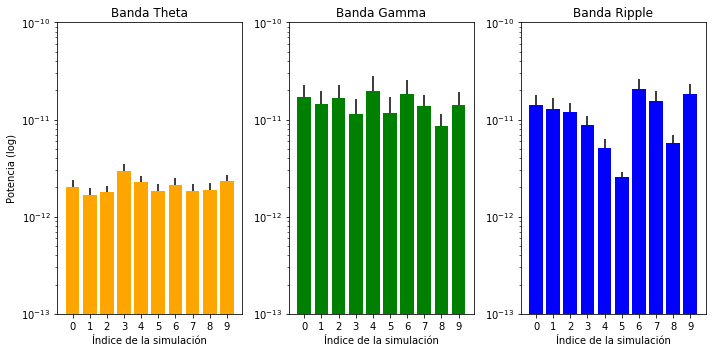

{'mean': [2.0356966925030238e-12, 1.6837453643485422e-12, 1.8076022690181763e-12, 2.9259214783549337e-12, 2.2730202105197398e-12, 1.8482213493130216e-12, 2.1153650376543052e-12, 1.8562903042625777e-12, 1.8884275894970326e-12, 2.3243905878274374e-12], 'std': [3.5997614324216981e-13, 2.8319350102420604e-13, 2.7497168575805613e-13, 5.9268325527873367e-13, 3.6486197874193502e-13, 3.2164860822995681e-13, 3.6499947846861823e-13, 3.0199922094809917e-13, 3.2606072827538808e-13, 3.5581735984799255e-13]}


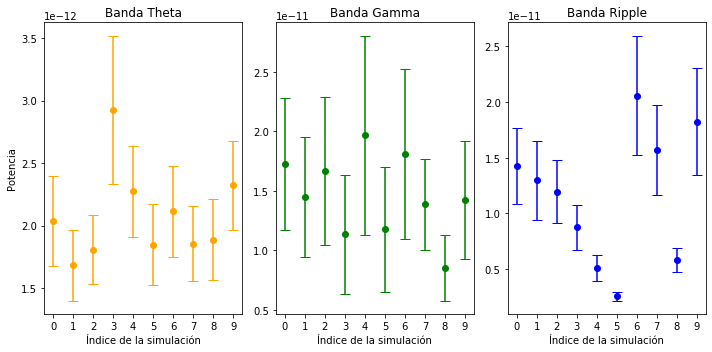

In [5]:
# Representamos los resultados de las bandas de frecuencia
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Banda Theta
axs[0].set_yscale('log')
axs[0].bar(
    np.arange(len(theta_bands["mean"])),
    theta_bands["mean"],
    yerr=theta_bands["std"],
    error_kw={'zorder': 2}, zorder=3,
    color="orange"
)
axs[0].set_ylim(1e-13, 1e-10)
axs[0].set_xticks(np.arange(len(theta_bands["mean"])))
axs[0].set_title("Banda Theta")
axs[0].set_ylabel("Potencia (log)")
axs[0].set_xlabel("Índice de la simulación")
# Banda Gamma
axs[1].set_yscale('log')
axs[1].bar(
    np.arange(len(gamma_bands["mean"])),
    gamma_bands["mean"],
    yerr=gamma_bands["std"],
    error_kw={'zorder': 2}, zorder=3,
    color="green"
)
axs[1].set_ylim(1e-13, 1e-10)
axs[1].set_xticks(np.arange(len(gamma_bands["mean"])))
axs[1].set_title("Banda Gamma")
axs[1].set_xlabel("Índice de la simulación")
# Banda Ripple
axs[2].set_yscale('log')
axs[2].bar(
    np.arange(len(ripple_bands["mean"])),
    ripple_bands["mean"],
    yerr=ripple_bands["std"],
    error_kw={'zorder': 2}, zorder=3,
    color="blue"
)
axs[2].set_ylim(1e-13, 1e-10)
axs[2].set_xticks(np.arange(len(ripple_bands["mean"])))
axs[2].set_xlabel("Índice de la simulación")
axs[2].set_title("Banda Ripple")
fig.tight_layout()
plt.show()


# Volvemos a realizar el gráfico pero con un gráfico de puntos y no te barras
fig2, axs2 = plt.subplots(1, 3, figsize=(10, 5))
# Banda Theta
x_theta = np.arange(len(theta_bands["mean"]))
axs2[0].errorbar(
    x_theta,
    theta_bands["mean"],
    yerr=theta_bands["std"],
    fmt='o',
    capsize=5,
    color="orange",
    zorder=3
)
axs2[0].set_xticks(x_theta)
axs2[0].set_title("Banda Theta")
axs2[0].set_ylabel("Potencia")
axs2[0].set_xlabel("Índice de la simulación")
# Banda Gamma
x_gamma = np.arange(len(gamma_bands["mean"]))
axs2[1].errorbar(
    x_gamma,
    gamma_bands["mean"],
    yerr=gamma_bands["std"],
    fmt='o',
    capsize=5,
    color="green",
    zorder=3
)
axs2[1].set_xticks(x_gamma)
axs2[1].set_title("Banda Gamma")
axs2[1].set_xlabel("Índice de la simulación")
# Banda Ripple
x_ripple = np.arange(len(ripple_bands["mean"]))
axs2[2].errorbar(
    x_ripple,
    ripple_bands["mean"],
    yerr=ripple_bands["std"],
    fmt='o',
    capsize=5,
    color="blue",
    zorder=3
)
axs2[2].set_xticks(x_ripple)
axs2[2].set_title("Banda Ripple")
axs2[2].set_xlabel("Índice de la simulación")
fig2.tight_layout()

print(theta_bands)

plt.show()

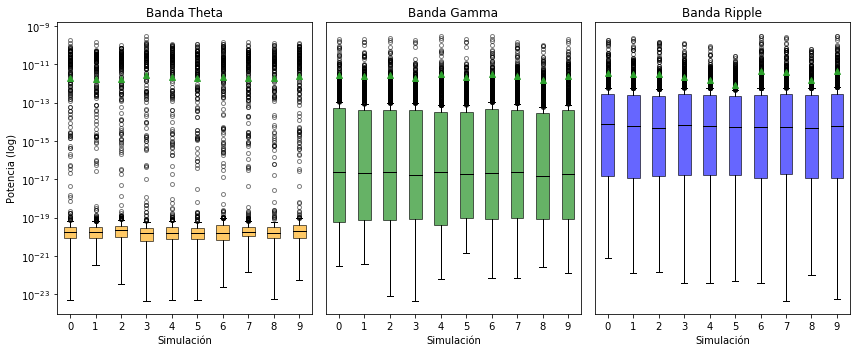

In [6]:
fig_box, axs_box = plt.subplots(1, 3, figsize=(12, 5))

# --- Banda Theta ---
axs_box[0].boxplot(
    theta_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="orange", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=True,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
axs_box[0].set_yscale('log')
axs_box[0].set_title("Banda Theta")
axs_box[0].set_xlabel("Simulación")
axs_box[0].set_ylabel("Potencia (log)")
# Matplotlib numera las cajas de 1 a N, así que para etiquetar en el eje X de 0 a 9:
N_sim = len(theta_values_per_sim)
axs_box[0].set_xticks(np.arange(1, N_sim + 1))
axs_box[0].set_xticklabels(np.arange(N_sim))


# --- Banda Gamma ---
axs_box[1].boxplot(
    gamma_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="green", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=True,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
axs_box[1].set_yscale('log')
axs_box[1].set_title("Banda Gamma")
axs_box[1].set_xlabel("Simulación")
# Ocultamos las marcas del eje Y para evitar redundancia
axs_box[1].set_yticks([])
axs_box[1].set_xticks(np.arange(1, N_sim + 1))
axs_box[1].set_xticklabels(np.arange(N_sim))


# --- Banda Ripple ---
axs_box[2].boxplot(
    ripple_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="blue", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=True,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
axs_box[2].set_yscale('log')
axs_box[2].set_title("Banda Ripple")
axs_box[2].set_xlabel("Simulación")
# Ocultamos las marcas del eje Y para evitar redundancia
axs_box[2].set_yticks([])
axs_box[2].set_xticks(np.arange(1, N_sim + 1))
axs_box[2].set_xticklabels(np.arange(N_sim))

fig_box.tight_layout()
plt.show()

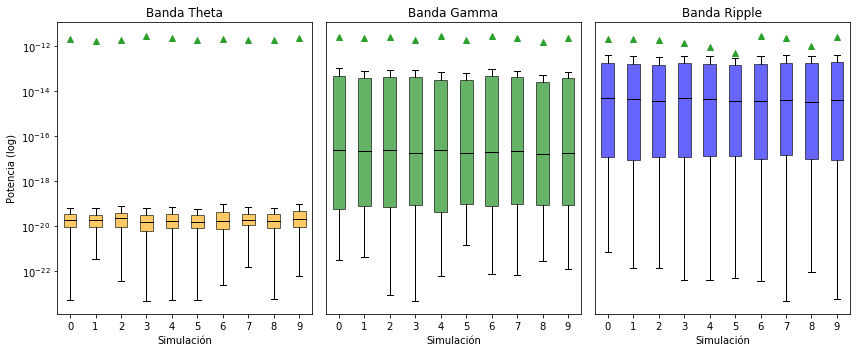

In [7]:
fig_box, axs_box = plt.subplots(1, 3, figsize=(12, 5))

# Número de simulaciones (para etiquetar el eje X)
N_sim = len(theta_values_per_sim)

# --- Banda Theta ---
axs_box[0].boxplot(
    theta_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="orange", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    showmeans=True
)
axs_box[0].set_yscale('log')
axs_box[0].set_title("Banda Theta")
axs_box[0].set_xlabel("Simulación")
axs_box[0].set_ylabel("Potencia (log)")
axs_box[0].set_xticks(np.arange(1, N_sim + 1))
axs_box[0].set_xticklabels(np.arange(N_sim))


# --- Banda Gamma ---
axs_box[1].boxplot(
    gamma_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="green", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    showmeans=True
)
axs_box[1].set_yscale('log')
axs_box[1].set_title("Banda Gamma")
axs_box[1].set_xlabel("Simulación")
axs_box[1].set_yticks([])  # Oculta marcas del eje Y
axs_box[1].set_xticks(np.arange(1, N_sim + 1))
axs_box[1].set_xticklabels(np.arange(N_sim))


# --- Banda Ripple ---
axs_box[2].boxplot(
    ripple_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="blue", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    showmeans=True
)
axs_box[2].set_yscale('log')
axs_box[2].set_title("Banda Ripple")
axs_box[2].set_xlabel("Simulación")
axs_box[2].set_yticks([])  # Oculta marcas del eje Y
axs_box[2].set_xticks(np.arange(1, N_sim + 1))
axs_box[2].set_xticklabels(np.arange(N_sim))

fig_box.tight_layout()
plt.show()

Ahora analizaremos la variación en las frecuencias pico.


In [8]:
# Diccionarios donde seguiremos guardando media y “std” (como en tu código original)
events_pf = {"mean": [], "std": []}
ripple_pf = {"mean": [], "std": []}

# Nuevas listas para almacenar los vectores crudos de cada simulación
events_values_per_sim = []
ripple_values_per_sim = []

# Recorremos evento y ripple por simulación
for events, ripples in zip(event_data, ripple_data):
    # events[2] es el array de frecuencias pico de eventos de esta simulación
    # ripples[1] es el array de frecuencias pico de ripples de esta simulación

    # 1.a) Guardamos los vectores crudos
    events_values_per_sim.append(events[2])
    ripple_values_per_sim.append(ripples[1])

    # 1.b) Calculamos la media de cada array
    mean_events = np.mean(events[2])
    mean_ripples = np.mean(ripples[1])
    events_pf["mean"].append(mean_events)
    ripple_pf["mean"].append(mean_ripples)

    # 1.c) Calculamos el “error” (tú lo definías como std/len). Lo dejamos igual:
    sem_events = np.std(events[2]) / len(events[2])
    sem_ripples = np.std(ripples[1]) / len(ripples[1])
    events_pf["std"].append(sem_events)
    ripple_pf["std"].append(sem_ripples)

WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double

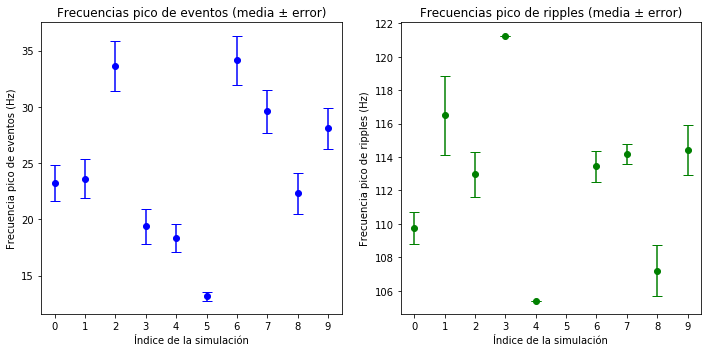

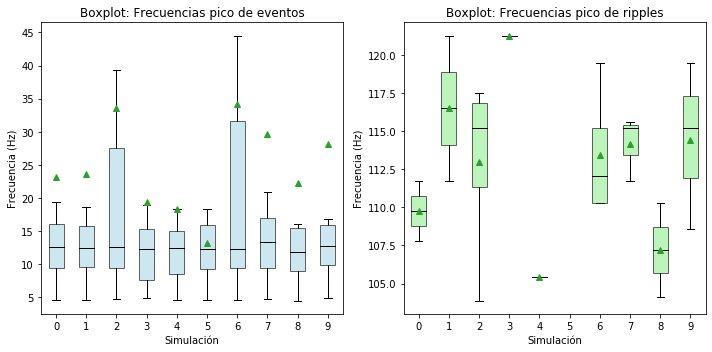

In [9]:
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 5))

# --- Frecuencias pico de eventos (errorbar) ---
axs3[0].errorbar(
    np.arange(len(events_pf["mean"])),
    events_pf["mean"],
    yerr=events_pf["std"],
    fmt='o',
    capsize=5,
    color="blue",
    zorder=3
)
axs3[0].set_ylabel("Frecuencia pico de eventos (Hz)")
axs3[0].set_xlabel("Índice de la simulación")
axs3[0].set_xticks(np.arange(len(events_pf["mean"])))
axs3[0].set_title("Frecuencias pico de eventos (media ± error)")

# --- Frecuencias pico de ripples (errorbar) ---
axs3[1].errorbar(
    np.arange(len(ripple_pf["mean"])),
    ripple_pf["mean"],
    yerr=ripple_pf["std"],
    fmt='o',
    capsize=5,
    color="green",
    zorder=3
)
axs3[1].set_ylabel("Frecuencia pico de ripples (Hz)")
axs3[1].set_xlabel("Índice de la simulación")
axs3[1].set_xticks(np.arange(len(ripple_pf["mean"])))
axs3[1].set_title("Frecuencias pico de ripples (media ± error)")

fig3.tight_layout()
plt.show()


# ---------------------------------------------------
# 3) GRAFICAR BOXPLOTS USANDO LOS VECTORES CRUDOS
# ---------------------------------------------------

fig_box2, axs_box2 = plt.subplots(1, 2, figsize=(10, 5))

# --- Boxplot para Frecuencias pico de eventos ---
axs_box2[0].boxplot(
    events_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
axs_box2[0].set_title("Boxplot: Frecuencias pico de eventos")
axs_box2[0].set_xlabel("Simulación")
axs_box2[0].set_ylabel("Frecuencia (Hz)")
# Ajustamos las etiquetas del eje X de 0 a N-1
N_sim_events = len(events_values_per_sim)
axs_box2[0].set_xticks(np.arange(1, N_sim_events + 1))
axs_box2[0].set_xticklabels(np.arange(N_sim_events))

# --- Boxplot para Frecuencias pico de ripples ---
axs_box2[1].boxplot(
    ripple_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="lightgreen", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
axs_box2[1].set_title("Boxplot: Frecuencias pico de ripples")
axs_box2[1].set_xlabel("Simulación")
axs_box2[1].set_ylabel("Frecuencia (Hz)")
# Igual para las etiquetas del eje X
N_sim_ripples = len(ripple_values_per_sim)
axs_box2[1].set_xticks(np.arange(1, N_sim_ripples + 1))
axs_box2[1].set_xticklabels(np.arange(N_sim_ripples))

fig_box2.tight_layout()
plt.show()

Ahora vamos a analizar la variación del tiempo de duración de los ripples.


In [10]:
# Diccionario para guardar media y SEM (tal como en tu código original)
duration_ripples = {"mean": [], "std": []}

# Nueva lista para almacenar los vectores crudos de duración de ripples por simulación
duration_ripples_per_sim = []

# Recorremos cada conjunto de ripples en ripple_data
for ripples in ripple_data:
    # ripples[2] es el array de duraciones de ripples de esta simulación

    # 1.a) Guardamos el vector crudo
    duration_ripples_per_sim.append(ripples[2])

    # 1.b) Calculamos la media de ese array y la guardamos
    mean_duration = np.mean(ripples[2])
    duration_ripples["mean"].append(mean_duration)

    # 1.c) Calculamos el SEM tal como lo hacías: std() / N
    sem_duration = np.std(ripples[2]) / len(ripples[2])
    duration_ripples["std"].append(sem_duration)

WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double

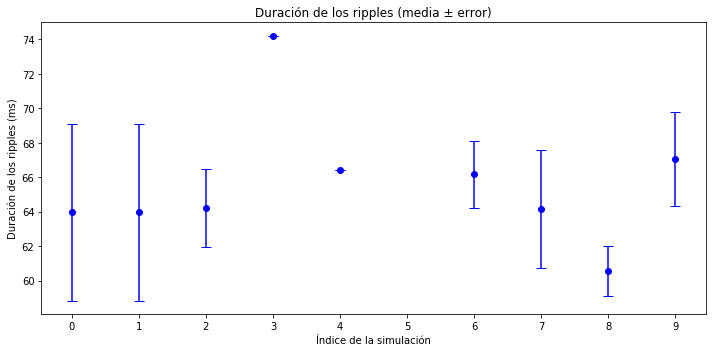

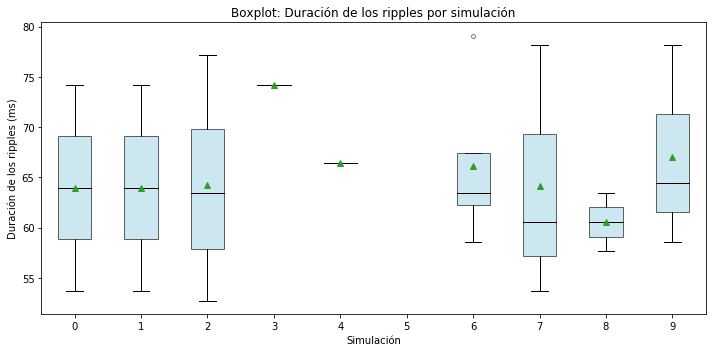

In [11]:
fig4, ax4 = plt.subplots(figsize=(10, 5))
ax4.errorbar(
    np.arange(len(duration_ripples["mean"])),
    duration_ripples["mean"],
    yerr=duration_ripples["std"],
    fmt='o',
    capsize=5,
    color="blue",
    zorder=3
)
ax4.set_ylabel("Duración de los ripples (ms)")
ax4.set_xlabel("Índice de la simulación")
ax4.set_xticks(np.arange(len(duration_ripples["mean"])))
ax4.set_title("Duración de los ripples (media ± error)")
fig4.tight_layout()
plt.show()


fig_box4, ax_box4 = plt.subplots(figsize=(10, 5))

ax_box4.boxplot(
    duration_ripples_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=True,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
ax_box4.set_title("Boxplot: Duración de los ripples por simulación")
ax_box4.set_xlabel("Simulación")
ax_box4.set_ylabel("Duración de los ripples (ms)")

# Ajustamos las etiquetas en el eje X de 0 a N-1
N_sim_duration = len(duration_ripples_per_sim)
ax_box4.set_xticks(np.arange(1, N_sim_duration + 1))
ax_box4.set_xticklabels(np.arange(N_sim_duration))

fig_box4.tight_layout()
plt.show()

## Métricas


Ahora vamos a ver qué métricas podemos usar para evlaluar los daños neuronales. Hay que tener en cuenta que debido a la "inestabilidad" de las simulaciones, necesitamos realizar varias a la vez, por lo que habrá que pensar también si es necesario representar algo más que una media y un error estándar de esta media.


La función `event_detection` del trabajo de Toellke nos proporciona los siguinetes datos a partir de un archivo `LFP.txt`:

- **Datos relacionados con eventos:**
  - Lista de eventos.
  - Lista de eventos filtrados.
  - Lista de frecuencias pico de cada evento.
  - Lista de las duraciones de cada evento.
- **Datos relacionados con SWRs:**
  - Lista de SWRs.
  - Lista de frecuencias pico de cada SWR.
  - Lista de duraciones de cada SWR.
- **Datos relacionados con la densidad espectral de potencia (PSD):**
  - Lista de densidad espectrla de potencia (PSD) en el rango de frecuencias "theta" (5-10 Hz).
  - Lista de densidad espectral de potencia (PSD) en el rango de frecuencias "gamma" (30-100 Hz).
  - Lista de densidad espectral de potencia (PSD) en el rango de frecuencias "ripples" (100-250 Hz).


A partir de estos datos, podemos probar a calcular las siguientes métricas:

- **Cantidades:**
  - Número de eventos.
  - Número de SWRs.
- **Duraciones:**
  - Duraciones de eventos.
  - Duraciones de SWRs.
- **Frecuencias:**
  - Frecuencias pico de eventos.
  - Frecuencias pico de SWRs.
- **Potencias:**
  - Potencia en el rango de frecuencias "theta".
  - Potencia en el rango de frecuencias "gamma".
  - Potencia en el rango de frecuencias "ripples".


In [12]:
# Definimos las rutas de las carpetas de validación
path1 = str(results_folder.parent / "healthy_validation_1")
path2 = str(results_folder.parent / "healthy_validation_2")
path3 = str(results_folder.parent / "healthy_validation_3")
path4 = str(results_folder.parent / "healthy_validation_4")
path5 = str(results_folder.parent / "healthy_validation_5")
path_N = str(results_folder.parent / "N_validation")
path_gmaxe = str(results_folder.parent / "gmaxe_validation")
path_gcan = str(results_folder.parent / "gCAN_validation")
path_gach = str(results_folder.parent / "gACh_validation")
path_flooding = str(results_folder.parent / "flooding_validation")
path_flooding_lim = str(results_folder.parent / "flooding_lim_validation")
path_jamming = str(results_folder.parent / "jamming_validation")
path_jamming_lim = str(results_folder.parent / "jamming_lim_validation")
path_scanning_higher = str(results_folder.parent /
                           "scanning_higher_validation")
path_scanning_higher_1 = str(results_folder.parent / "scanning_higher_1_validation")
parth_scanning_higher_2 = str(results_folder.parent / "scanning_higher_2_validation")
path_scanning_higher_3 = str(results_folder.parent / "scanning_higher_3_validation")
path_scanning_higher_full = str(results_folder.parent / "scanning_higher_full_validation")
path_scanning_lower = str(results_folder.parent / "scanning_lower_validation")
path_scanning_lower_1 = str(results_folder.parent / "scanning_lower_1_validation")
path_scanning_lower_2 = str(results_folder.parent / "scanning_lower_2_validation")
path_scanning_lower_3 = str(results_folder.parent / "scanning_lower_3_validation")
path_scanning_lower_full = str(results_folder.parent / "scanning_lower_full_validation")
path_nonce_1 = str(results_folder.parent / "nonce_1_validation")
path_nonce_1_1 = str(results_folder.parent / "nonce_1.1_validation")
paths_nonce_2 = []
for i in range(1, 11):
    paths_nonce_2.append(str(results_folder.parent / f"nonce_2.{i}_validation"))

# Cargamos los datos de las carpetas de validación
data_dict = data_to_dict(str(results_folder))
data_dict_1 = data_to_dict(path1)
data_dict_2 = data_to_dict(path2)
data_dict_3 = data_to_dict(path3)
data_dict_4 = data_to_dict(path4)
data_dict_5 = data_to_dict(path5)
data_dict_N = data_to_dict(path_N)
data_dict_gmaxe = data_to_dict(path_gmaxe)
data_dict_gcan = data_to_dict(path_gcan)
data_dict_gach = data_to_dict(path_gach)
data_dict_flooding = data_to_dict(path_flooding)
data_dict_flooding_lim = data_to_dict(path_flooding_lim)
data_dict_jamming = data_to_dict(path_jamming)
data_dict_jamming_lim = data_to_dict(path_jamming_lim)
# data_dict_scanning_higher = data_to_dict(path_scanning_higher)
# data_dict_scanning_higher_1 = data_to_dict(path_scanning_higher_1)
# data_dict_scanning_higher_2 = data_to_dict(parth_scanning_higher_2)
# data_dict_scanning_higher_3 = data_to_dict(path_scanning_higher_3)
data_dict_scanning_higher_full = data_to_dict(path_scanning_higher_full)
# data_dict_scanning_lower = data_to_dict(path_scanning_lower)
# data_dict_scanning_lower_1 = data_to_dict(path_scanning_lower_1)
# data_dict_scanning_lower_2 = data_to_dict(path_scanning_lower_2)
# data_dict_scanning_lower_3 = data_to_dict(path_scanning_lower_3)
data_dict_scanning_lower_full = data_to_dict(path_scanning_lower_full)
data_dict_nonce_1 = data_to_dict(path_nonce_1)
data_dict_nonce_1_1 = data_to_dict(path_nonce_1_1)
dicts_nonce_2 = []
for path_nonce in paths_nonce_2:
    data_dict_nonce_2 = data_to_dict(path_nonce)
    dicts_nonce_2.append(data_dict_nonce_2)


# Creamos listas de diccionarios para las validaciones y comparaciones
dicts_validation = [data_dict_1,
                    data_dict_2,
                    data_dict_3,
                    data_dict_4,
                    data_dict_5]
dicts_comparison = [data_dict_N,
                    data_dict_gmaxe,
                    data_dict_gcan,
                    data_dict_gach]
dicts_attacks = [data_dict_flooding,
                 data_dict_flooding_lim,
                 data_dict_jamming,
                 data_dict_jamming_lim,
                 data_dict_scanning_higher_full,
                 data_dict_scanning_lower_full,
                 data_dict_nonce_1]
# dict_scanning = [
#     data_dict_scanning_higher,
#     data_dict_scanning_higher_1,
#     data_dict_scanning_higher_2,
#     data_dict_scanning_higher_3,
#     data_dict_scanning_lower,
#     data_dict_scanning_lower_1,
#     data_dict_scanning_lower_2,
#     data_dict_scanning_lower_3
# ]

# Creamos las etiquetas para las validaciones y comparaciones
labels_validation = [
    "Healthy validation 1",
    "Healthy validation 2",
    "Healthy validation 3",
    "Healthy validation 4",
    "Healthy validation 5"
]
labels_comparison = [
    "N validation",
    "gmaxe validation",
    "gCAN validation",
    "gACh validation"
]
labels_attacks = [
    "Flooding",
    "Flooding_lim",
    "Jamming",
    "Jamming_lim",
    "Scanning higher",
    "Scanning lower",
    "Nonce 1",
    "Nonce 2"
]
# labels_scanning = [
#     "Scanning higher",
#     "Scanning higher 1",
#     "Scanning higher 2",
#     "Scanning higher 3",
#     "Scanning lower",
#     "Scanning lower 1",
#     "Scanning lower 2",
#     "Scanning lower 3"
# ]
labels_nonce_2 = [
    "Nonce 2.1",
    "Nonce 2.2",
    "Nonce 2.3",
    "Nonce 2.4",
    "Nonce 2.5",
    "Nonce 2.6",
    "Nonce 2.7",
    "Nonce 2.8",
    "Nonce 2.9",
    "Nonce 2.10"
]

### Cantidad de eventos y SWRs


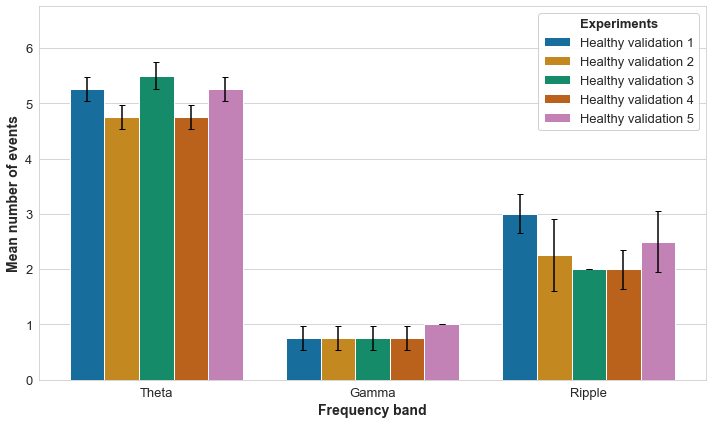

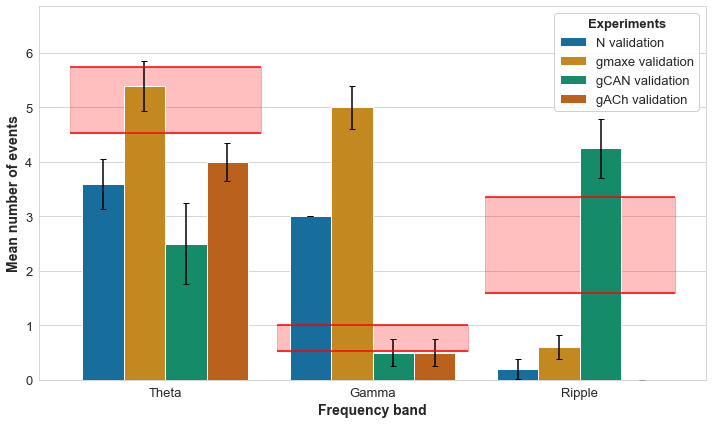

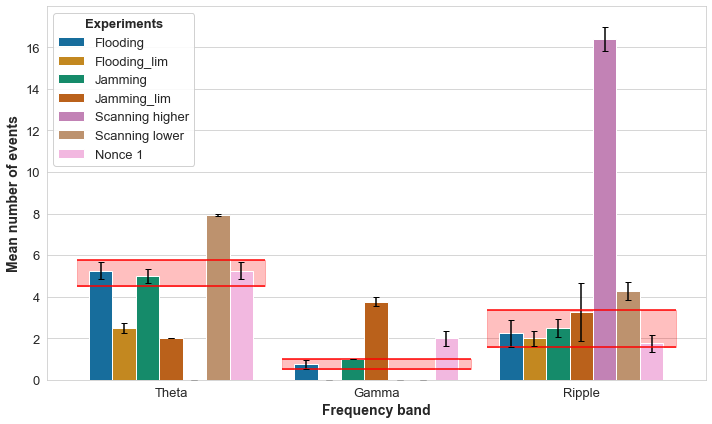

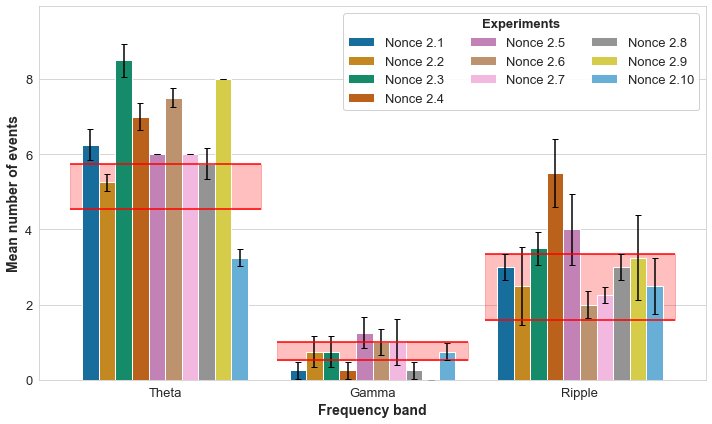

In [13]:
# Gráficas de validación de simulaciones healthy
lims = n_detects_plot(
    data_dict=dicts_validation,
    labels=labels_validation,
    figsize=(10, 6),
    return_lims=True
)

# Gráficas de comparación de healthy con ataques definidos con parámetros de la simulación
n_detects_plot(
    data_dict=dicts_comparison,
    labels=labels_comparison,
    figsize=(10, 6),
    lims=lims
)

# Gráficas de comparación de healthy con ataques a los archivos EEG
n_detects_plot(
    data_dict=dicts_attacks,
    labels=labels_attacks,
    figsize=(10, 6),
    lims=lims
)

# Gráficas de comparación de healthy con scanning
# n_detects_plot(
#     data_dict=dict_scanning,
#     labels=labels_scanning,
#     figsize=(10, 6),
#     lims=lims
# )

# Gráficas de comparación de healthy con nonce 2
n_detects_plot(
    data_dict=dicts_nonce_2,
    labels=labels_nonce_2,
    figsize=(10, 6),
    lims=lims,
    ncol=3
)

### Duración de eventos y SWRs


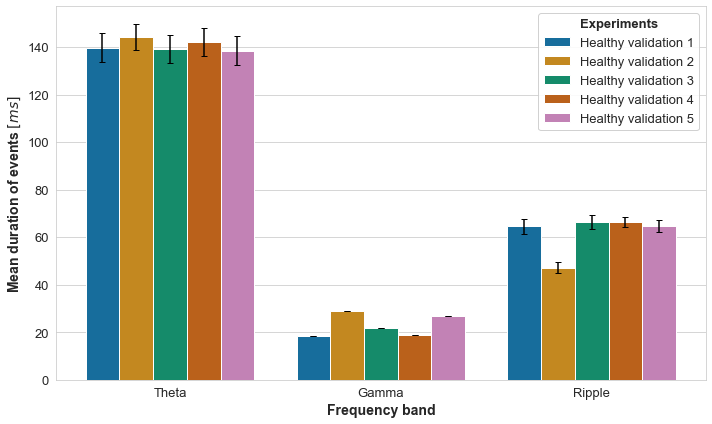

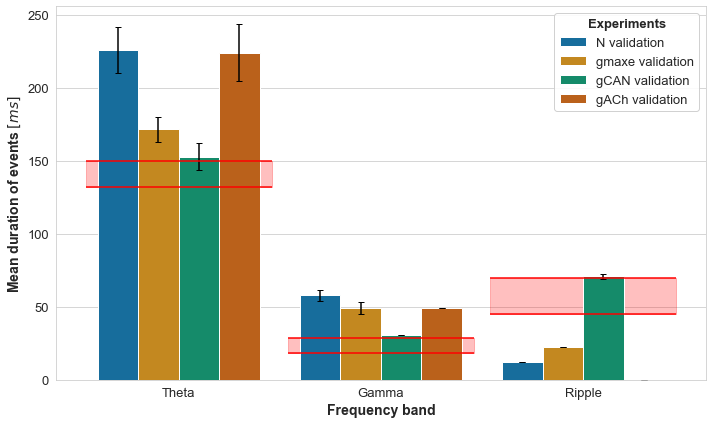

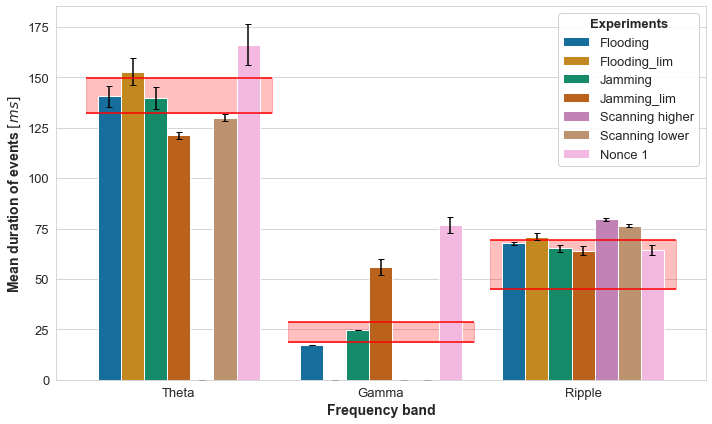

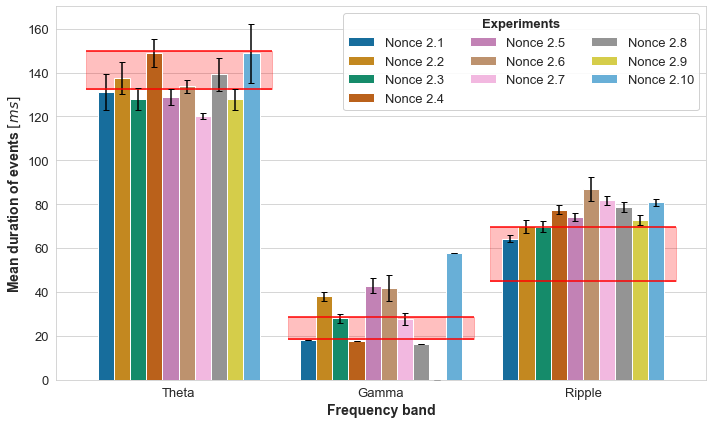

In [17]:
# Gráficas de duración de eventos detectados en validaciones healthy
lims = durations_plot(
    data_dict=dicts_validation,
    labels=labels_validation,
    figsize=(10, 6),
    return_lims=True
)

# Gráficas de duración de eventos detectados en comparación healthy con ataques
durations_plot(
    data_dict=dicts_comparison,
    labels=labels_comparison,
    figsize=(10, 6),
    lims=lims,
)

# Gráficas de duración de eventos detectados en comparación healthy con ataques a los archivos EEG
durations_plot(
    data_dict=dicts_attacks,
    labels=labels_attacks,
    figsize=(10, 6),
    lims=lims
)

# Gráficas de duración de eventos detectados en comparación healthy con scanning
# durations_plot(
#     data_dict=dict_scanning,
#     labels=labels_scanning,
#     figsize=(10, 6),
#     lims=lims
# )

# Gráficas de duración de eventos detectados en comparación healthy con nonce 2
durations_plot(
    data_dict=dicts_nonce_2,
    labels=labels_nonce_2,
    figsize=(10, 6),
    lims=lims,
    ncol=3
)

### Frecuencias pico de eventos y SWRs


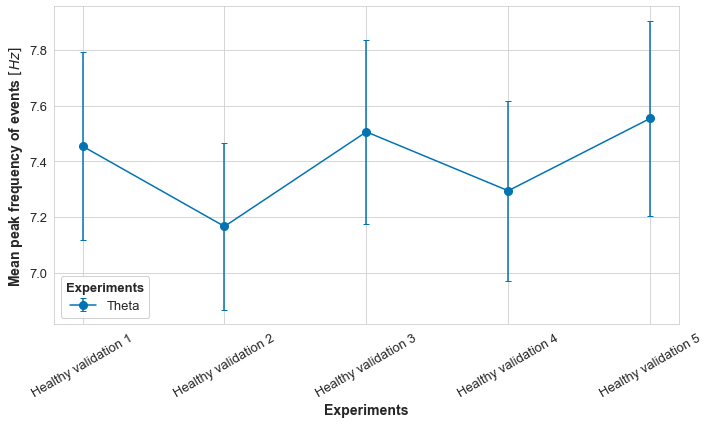

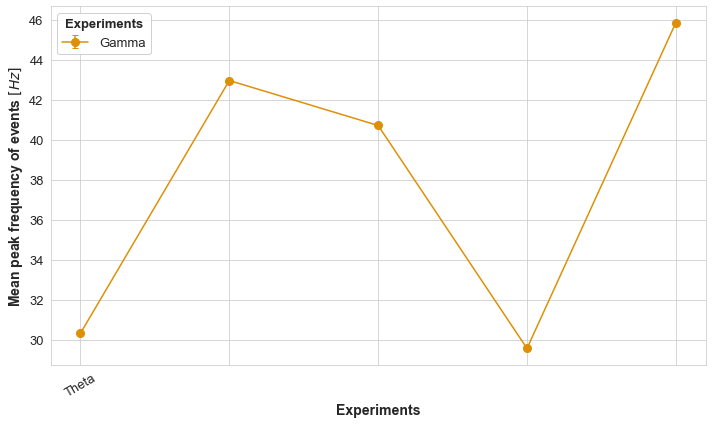

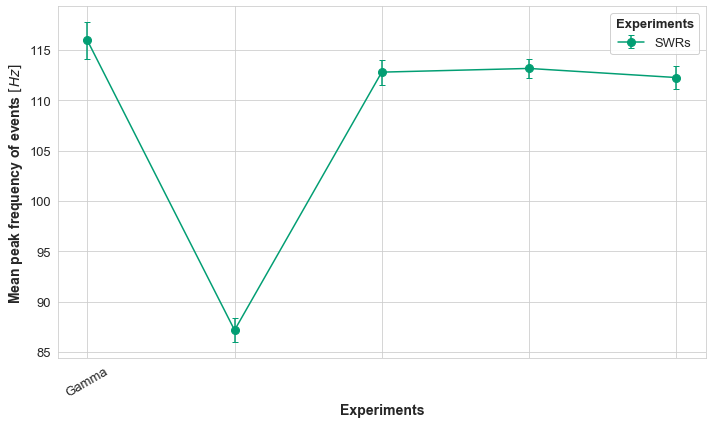

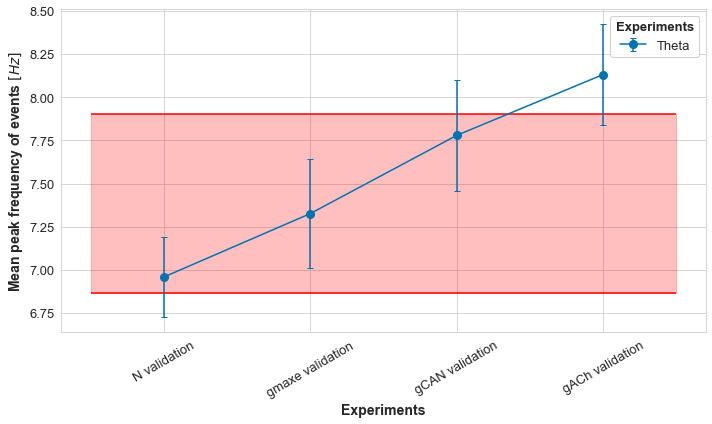

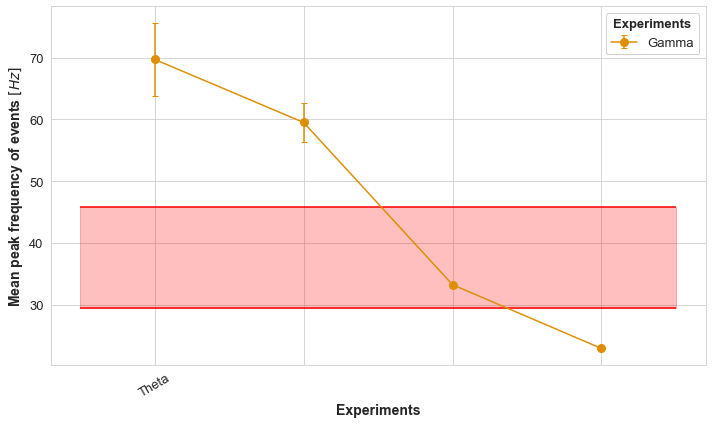

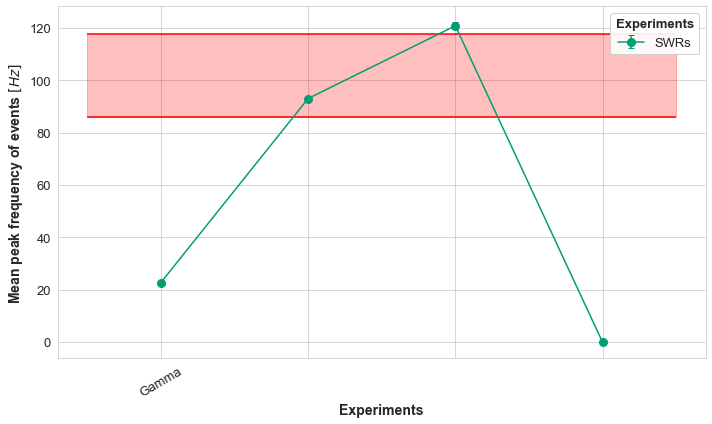

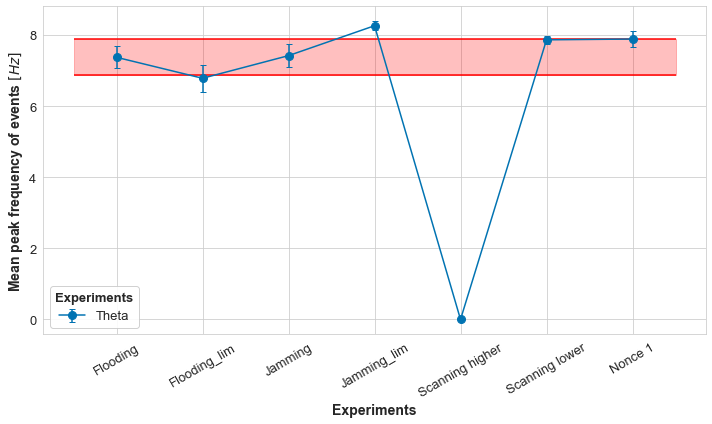

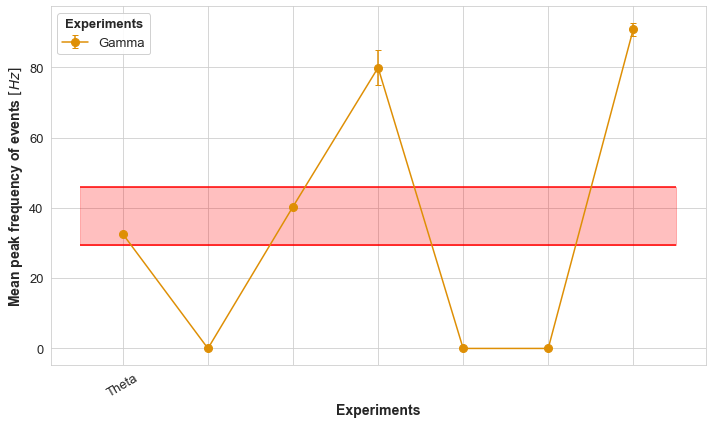

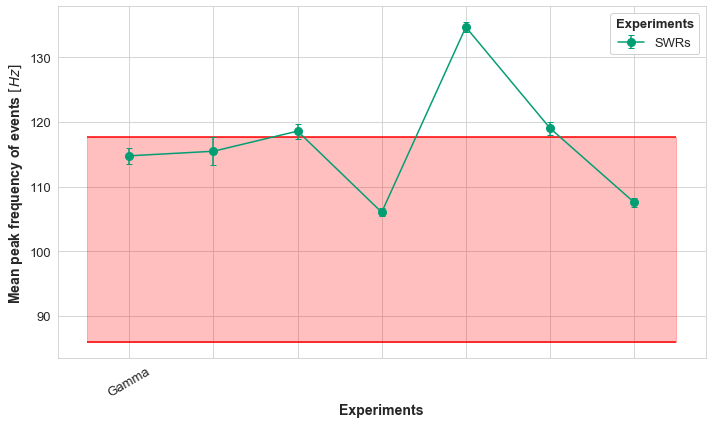

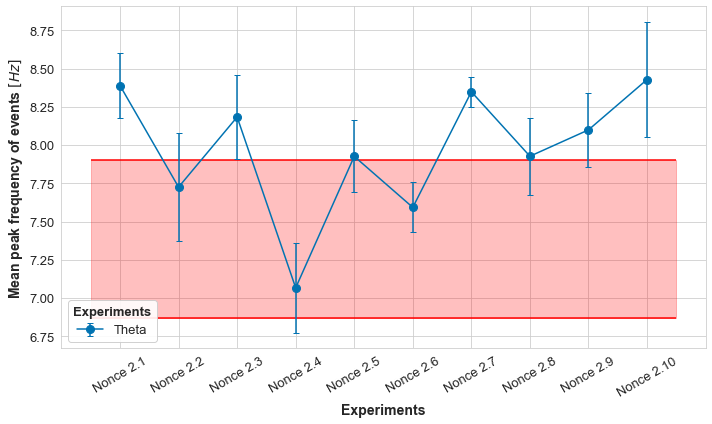

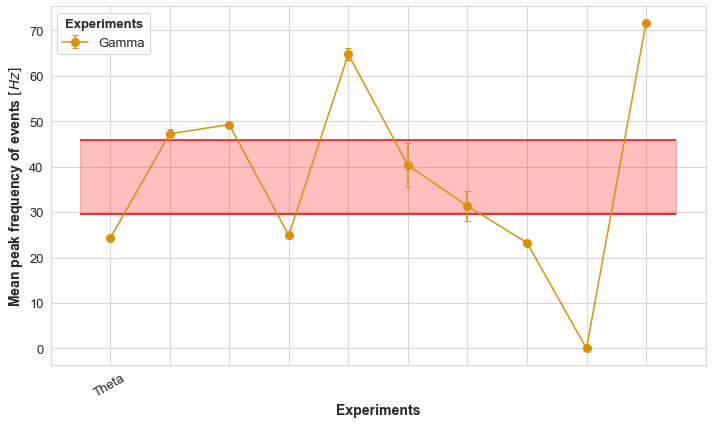

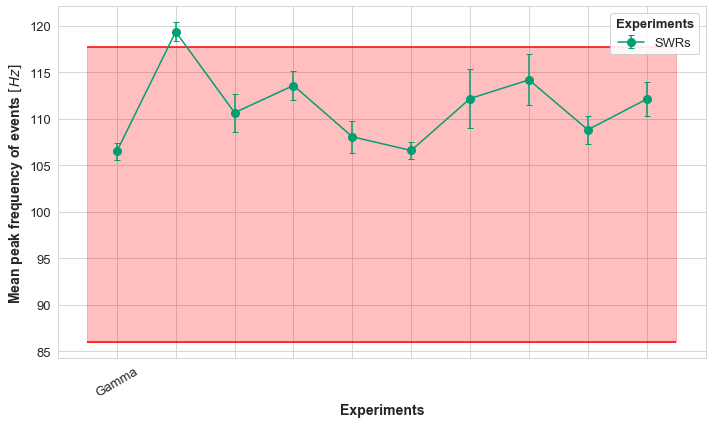

In [15]:
# Gráficas de frecuencias pico de eventos detectados en validaciones healthy
lims = peak_freqs_plot(
    data_dict=dicts_validation,
    labels=labels_validation,
    figsize=(10, 6),
    xrotation=30,
    return_lims=True
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con ataques
peak_freqs_plot(
    data_dict=dicts_comparison,
    labels=labels_comparison,
    figsize=(10, 6),
    xrotation=30,
    lims=lims
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con ataques a los archivos EEG
peak_freqs_plot(
    data_dict=dicts_attacks,
    labels=labels_attacks,
    figsize=(10, 6),
    xrotation=30,
    lims=lims
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con scanning
# peak_freqs_plot(
#     data_dict=dict_scanning,
#     labels=labels_scanning,
#     figsize=(10, 6),
#     lims=lims
# )

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con nonce 2
peak_freqs_plot(
    data_dict=dicts_nonce_2,
    labels=labels_nonce_2,
    figsize=(10, 6),
    xrotation=30,
    lims=lims
)

### PSD


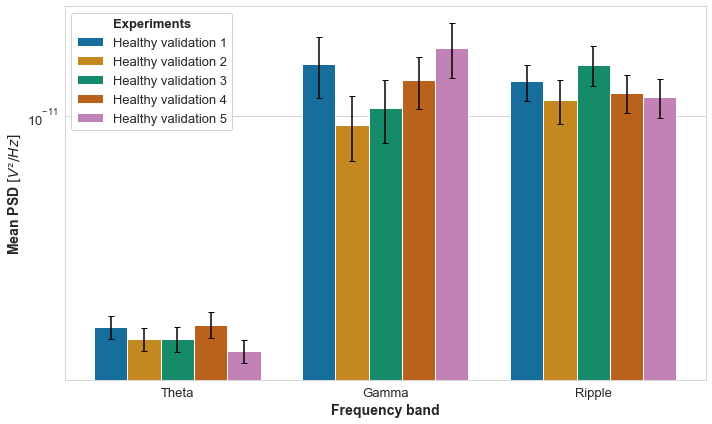

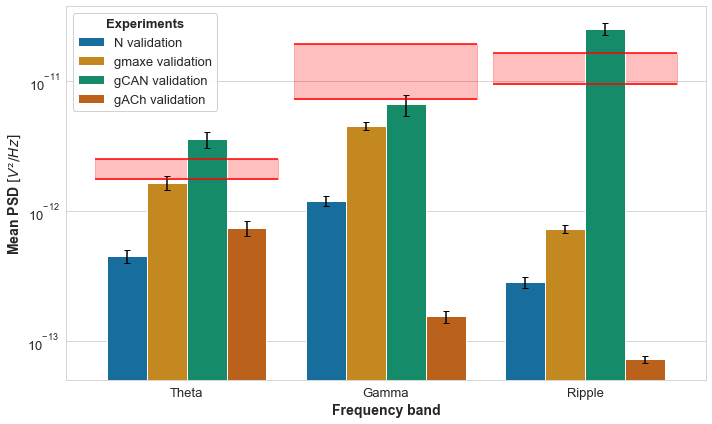

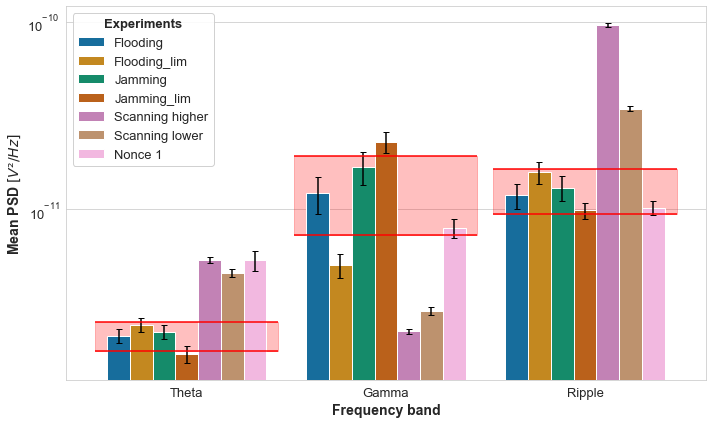

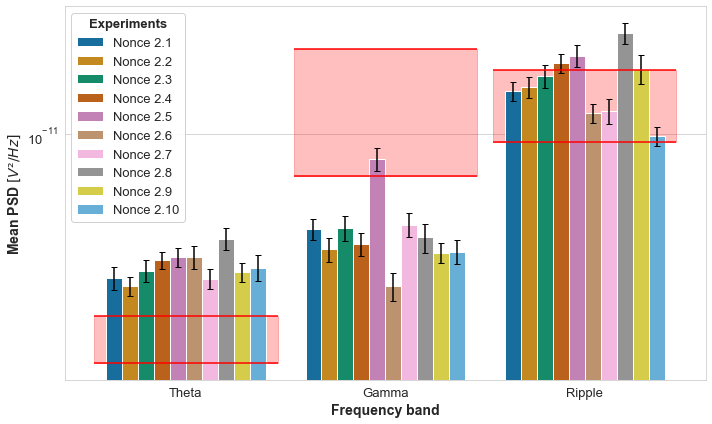

In [16]:
# Gráficas de psd de eventos detectados en validaciones healthy
lims = psd_plot(
    data_dict=dicts_validation,
    labels=labels_validation,
    figsize=(10, 6),
    return_lims=True
)

# Gráficas de psd de eventos detectados en comparación healthy con ataques
psd_plot(
    data_dict=dicts_comparison,
    labels=labels_comparison,
    figsize=(10, 6),
    lims=lims
)

# Gráficas de psd de eventos detectados en comparación healthy con ataques a los archivos EEG
psd_plot(
    data_dict=dicts_attacks,
    labels=labels_attacks,
    figsize=(10, 6),
    lims=lims
)

# Gráficas de psd de eventos detectados en comparación healthy con scanning
# psd_plot(
#     data_dict=dict_scanning,
#     labels=labels_scanning,
#     figsize=(10, 6),
#     lims=lims
# )

# Gráficas de psd de eventos detectados en comparación healthy con nonce 2
psd_plot(
    data_dict=dicts_nonce_2,
    labels=labels_nonce_2,
    figsize=(10, 6),
    lims=lims
)